# Natural Language Processing with Disaster Tweets Project
## by: Kevin Boyle (CU-B MS-DS)

### Introduction / Brief Description of the Problem and Data

Hello! For this project, I will be looking at tweets about disasters and classifying whether or not they are about real disasters.  

Twitter has become an important tool for communication, especially in terms of uncertainty or danger. Because people tweet out disaster information in real time, more agencies are becoming interested in monitoring twitter. However, there is also a significant amount of "fake news" on the web, and in particular on Twitter, that needs to be weeded out.

I will be utilizing various NLP techniques as well as recurrent neural networks (LSTM, GRU) that I will be training on the training data set to predict which tweets are about real disasters and which one's arent. 

The dataset I'll be using is of 10,000 tweets that were hand classified. I was able to download it locally from Kaggle here: https://www.kaggle.com/competitions/nlp-getting-started/data

To start, I am going to import all relevant libraries/packages, and then load in the complete set of data files for training/testing/submitting.

In [306]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import contractions
import re
import nltk
import sklearn
#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, GRU

from sklearn.model_selection import train_test_split

In [307]:
# get data
traindata = pd.read_csv('Data For NLP/train.csv')
testdata = pd.read_csv('Data For NLP/test.csv')
samplesubmission = pd.read_csv('Data For NLP/sample_submission.csv')

### Exploratory Data Analysis (EDA)

To start the analysis of the training data set, I am just going to gather high level information by using the .info() function.

In [308]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [309]:
traindata['target'].unique()

array([1, 0])

From this result, we can gather a few key pieces of information. We know that there are five columns:
* id: a unique integer identifying each tweet. No nulls/NaNs in this column.
* keyword: object, there are 61 rows with NaN in this data set, so for the most part this is populated.
* location: object type, there are 2553 rows with NaN, which comes out to 33.2% of the data set.
* text: this is object type as well, and is the actual text of the tweets in question. No NaNs.
* target: this is an integer, which are either 0 or 1 (based on the unique call on the target column), that identifies whether a tweet is about a real disaster (1) or not a real disaster (0). Let's now find all the unique values in the target column to confirm.

Now I am going to dive a little deeper by checking out the first few twenty or so tweets in the data set, as well as some information about the length of each tweet.

In [310]:
traindata['text'].head(20)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

In [311]:
traindata["length"] = traindata["text"].apply(lambda x : len(x))

print("Train Length Statistics")
print(traindata["length"].describe())

Train Length Statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


From the resulting information, we can see that the tweets in the training data set are anywhere from 7 to 157 characters. The average is around 101 characters. Hopefully that will be enough characters in each tweet to train our model on correctly identifying whether the tweet is about a real disaster or not!

Finally, I will see what the breakdown of real disaster tweets vs fake disaster tweets is by creating a histogram on the counts in the target column.


[Text(0.5, 1.0, 'Counts per Target Value')]

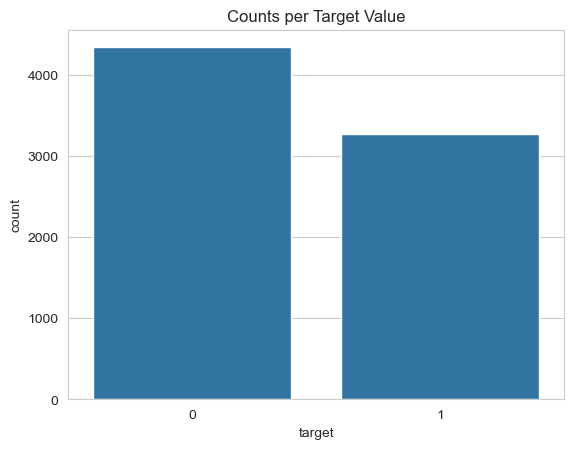

In [312]:
# visualize targets
sns.countplot(data=traindata, x='target').set(title='Counts per Target Value')

Now that we have some information about the training data set, we will now clean up the data so that it is most useful for our model.

For the purposes of this assignment, we are going to make the following changes to the tweet text to hopefully make them better for the training.

* Remove URLs, HTMLs, user tags (@ sign and everything adjacent to it), and all punctuation
* Lowercase all text
* Lemmatize words
* Tokenize text

Note: the following helper functions were inspired by checking out regex functions online for preprocessing tweet data, particularly in this kaggle doc: https://www.kaggle.com/code/nabanitaroy/eda-and-tf-idf-prediction-model-with-80-accuracy

In [313]:
# set constants
random_state = 49
STOPWORDS = set(stopwords.words('english'))

# remove urls
def remove_urls(text):
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# remove hmtmls
def remove_html(text):
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# remove @ and #
def remove_tags(text):
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

# put all words in lowercase
def lower_case(text):
    return text.lower()

# clean and lemmatize words 
def clean_lemmatize(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

# apply to training data
functions = [remove_urls, remove_html, remove_tags, lower_case, clean_lemmatize]
for func in functions: 
    traindata['text'] = traindata['text'].apply(func) 

In [314]:
traindata['text'].head(20)

0            deed reason earthquake may allah forgive u
1                 forest fire near la ronge sask canada
2     resident asked shelter place notified officer ...
3     13000 people receive wildfire evacuation order...
4     got sent photo ruby alaska smoke wildfire pour...
5     rockyfire update california hwy 20 closed dire...
6     flood disaster heavy rain cause flash flooding...
7                           i am top hill see fire wood
8     there is emergency evacuation happening buildi...
9                       i am afraid tornado coming area
10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa 18 19 ...
13                      flood bago myanmar arrived bago
14        damage school bus 80 multi car crash breaking
15                                          what is man
16                                           love fruit
17                                        summer

In [315]:
# tokenize 
tokenizer = Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(traindata['text'].values)

token_X = tokenizer.texts_to_sequences(traindata['text'].values)
token_X = pad_sequences(token_X)
token_X.shape
token_df = pd.DataFrame(token_X)
for col_id in range(token_X.shape[1]):
    traindata[str(col_id)] = token_df[col_id]

Now we are going to check out the traindata data set again, this time as a tokenized df. We can drop the text, keyword, and location columns as the text column is now tokenized.

In [316]:
# final look at data before starting model
traindata = traindata.drop('text', axis=1)
traindata = traindata.drop('length',axis=1)
traindata = traindata.drop('keyword', axis=1)
traindata = traindata.drop('location', axis=1)

traindata.head()

,id,target,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,4055,463,166,77,1425,4056,15
1,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,116,3,158,511,1084
2,5,1,0,0,0,0,0,0,0,0,...,1557,1426,1913,464,326,172,1913,464,376,964
3,6,1,0,0,0,0,0,0,0,0,...,0,0,0,2582,10,4057,86,172,376,40
4,7,1,0,0,0,0,0,0,0,0,...,0,0,0,37,1085,121,1558,195,86,103


### Model Architecture

Now with the data clean and tokenized, we will start working with our neural network models. In particular, we are going to use two recurrent neural networks: an LSTM (long short term memory), as well as a GRU (gated recurrent unit).

First, we are going split the training data into 2 (X_train, 

In [317]:
# split data 85/15 training-validation
x = traindata[traindata.columns[~traindata.columns.isin(['target','id'])]]
y = traindata['target']
trainX, valX, trainy, valy = train_test_split(x, y, test_size=0.15, random_state=42)

print(trainX.head(10))

      0  1  2  3  4  5  6  7  8    9  ...    12    13    14    15    16    17  \
2318  0  0  0  0  0  0  0  0  0  118  ...    29   506   830   179   209  1214   
6341  0  0  0  0  0  0  0  0  0    0  ...     0     0    27   352  2950   251   
1097  0  0  0  0  0  0  0  0  0    0  ...     0     0     0     0   966    35   
548   0  0  0  0  0  0  0  0  0    0  ...  1042   340  4285   168   787  1275   
6521  0  0  0  0  0  0  0  0  0    0  ...     0     0     0  2600     4    45   
4291  0  0  0  0  0  0  0  0  0    0  ...  1538  1840    64  1378    80  2529   
6382  0  0  0  0  0  0  0  0  0    0  ...   139   481    46   135   489    44   
3027  0  0  0  0  0  0  0  0  0    0  ...     0     0     0   166  1412  1337   
1429  0  0  0  0  0  0  0  0  0    0  ...  1325   455    92   244    79   612   
6458  0  0  0  0  0  0  0  0  0    0  ...  1932  1377  2171  4034   204    46   

        18    19    20    21  
2318   547    29   506   926  
6341  4032   145  1395     8  
1097   121   49

The network has a visible layer with 1 input, a hidden layer with 22 LSTM neurons, and an output layer. For the LSTM blocks, a sigmoid activation function is used. The network is trained for 10 epochs, and a dropout of 0.2 is utilized.

I am using Adam optimization as well as binary crossentropy loss.

In [318]:
#declare metrics for analysis during training
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

# create and fit the LSTM network
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=5000, output_dim=22, input_length=token_X.shape[1]))
model_LSTM.add(LSTM(22,dropout=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy', recall, precision])

In [319]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 22, 22)            110000    
                                                                 
 lstm_30 (LSTM)              (None, 22)                3960      
                                                                 
 dense_54 (Dense)            (None, 1)                 23        
                                                                 
Total params: 113983 (445.25 KB)
Trainable params: 113983 (445.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [320]:
history = model.fit(trainX, trainy, epochs = 10, verbose = 1, batch_size = 32, validation_data = (valX, valy))

Epoch 1/10
203/203 [==============================] - 4s 17ms/step - loss: 0.2085 - accuracy: 0.9217 - recall_28: 0.8838 - precision_28: 0.9303 - val_loss: 0.5435 - val_accuracy: 0.7767 - val_recall_28: 0.6965 - val_precision_28: 0.7634
Epoch 2/10
203/203 [==============================] - 3s 17ms/step - loss: 0.2025 - accuracy: 0.9277 - recall_28: 0.8885 - precision_28: 0.9399 - val_loss: 0.5569 - val_accuracy: 0.7723 - val_recall_28: 0.7108 - val_precision_28: 0.7473
Epoch 3/10
203/203 [==============================] - 3s 17ms/step - loss: 0.1939 - accuracy: 0.9305 - recall_28: 0.8935 - precision_28: 0.9416 - val_loss: 0.5698 - val_accuracy: 0.7653 - val_recall_28: 0.7373 - val_precision_28: 0.7226
Epoch 4/10
203/203 [==============================] - 3s 17ms/step - loss: 0.1884 - accuracy: 0.9278 - recall_28: 0.8932 - precision_28: 0.9359 - val_loss: 0.5744 - val_accuracy: 0.7636 - val_recall_28: 0.7189 - val_precision_28: 0.7278
Epoch 5/10
203/203 [==============================] 

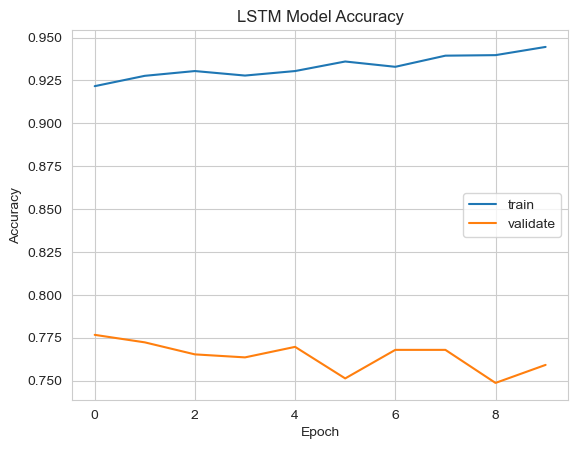

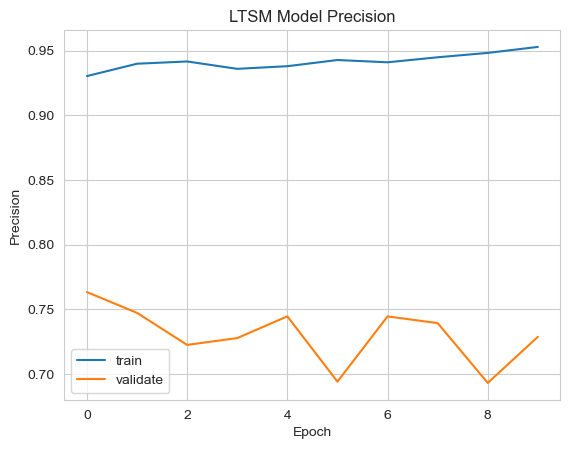

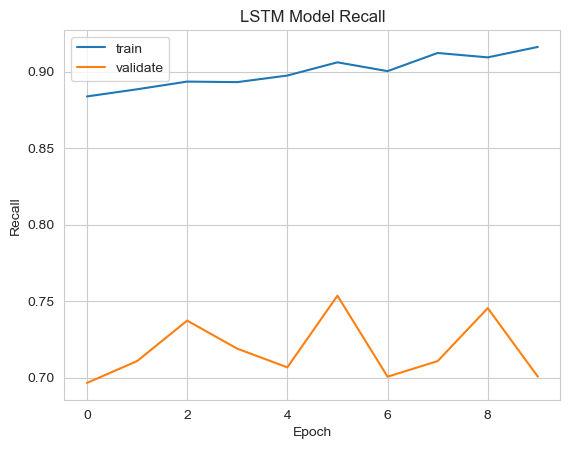

In [321]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

#precision
plt.plot(history.history['precision_28'])
plt.plot(history.history['val_precision_28'])
plt.title('LTSM Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

#recall
plt.plot(history.history['recall_28'])
plt.plot(history.history['val_recall_28'])
plt.title('LSTM Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

As you can see, it appears as though the LTSM model has a high accuracy on training rate, but once it tests itself on the validation data, the validation results are worse. It has around a 78% accuracy rate for model accuracy. Let's see if GRU would perform better with this data!

In [322]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim = 5000, output_dim=22, input_length=token_X.shape[1]))
model_GRU.add(Bidirectional(GRU(32)))
model_GRU.add(Dense(16, activation='relu'))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy', recall, precision])
model_GRU.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 22, 22)            110000    
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                10752     
 ional)                                                          
                                                                 
 dense_67 (Dense)            (None, 16)                1040      
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 121809 (475.82 KB)
Trainable params: 121809 (475.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [323]:
history_gru = model_GRU.fit(trainX, trainy, epochs = 10, batch_size = 32, verbose = 1, validation_data = (valX, valy))

Epoch 1/10
203/203 [==============================] - 15s 63ms/step - loss: 0.6855 - accuracy: 0.5659 - recall_30: 0.0223 - precision_30: 0.4052 - val_loss: 0.6802 - val_accuracy: 0.5701 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 2/10
203/203 [==============================] - 7s 33ms/step - loss: 0.6719 - accuracy: 0.5705 - recall_30: 3.5971e-04 - precision_30: 1.0000 - val_loss: 0.6596 - val_accuracy: 0.5709 - val_recall_30: 0.0020 - val_precision_30: 1.0000
Epoch 3/10
203/203 [==============================] - 6s 31ms/step - loss: 0.6015 - accuracy: 0.6620 - recall_30: 0.2216 - precision_30: 0.9640 - val_loss: 0.5684 - val_accuracy: 0.7312 - val_recall_30: 0.4257 - val_precision_30: 0.8932
Epoch 4/10
203/203 [==============================] - 6s 29ms/step - loss: 0.4650 - accuracy: 0.8079 - recall_30: 0.6442 - precision_30: 0.8758 - val_loss: 0.5006 - val_accuracy: 0.7811 - val_recall_30: 0.6110 - val_precision_30: 0.8357
Epoch 5/10
203/203 [===================

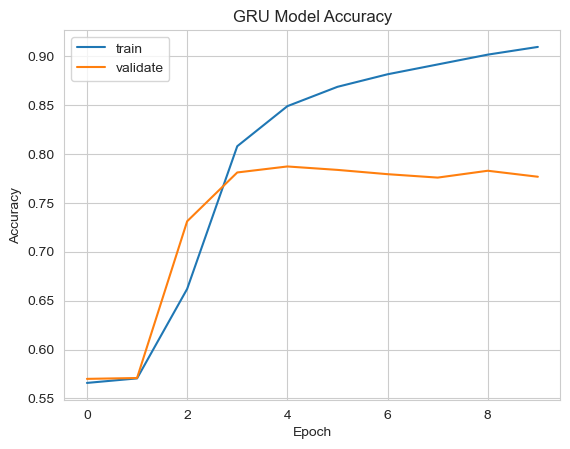

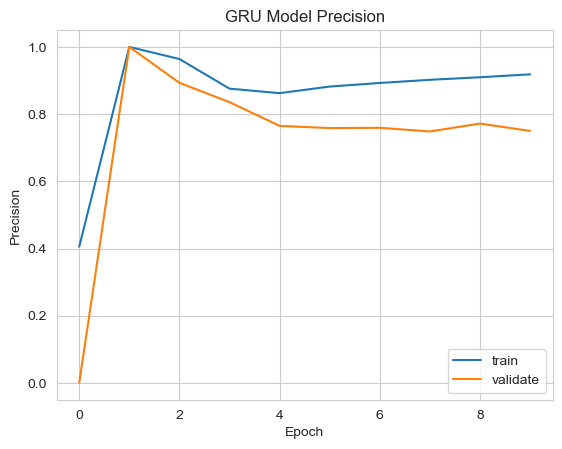

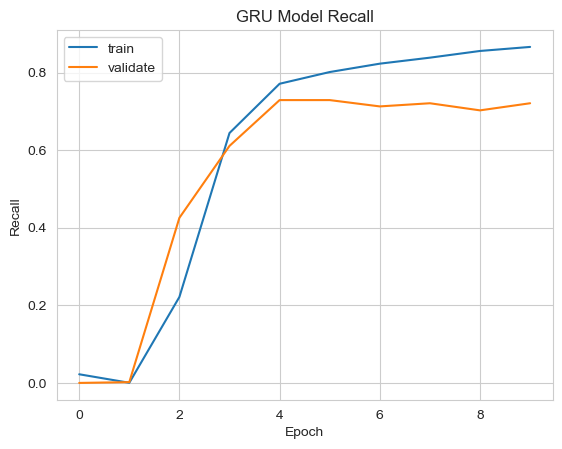

In [325]:
#accuracy
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

#precision
plt.plot(history_gru.history['precision_30'])
plt.plot(history_gru.history['val_precision_30'])
plt.title('GRU Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

#recall
plt.plot(history_gru.history['recall_30'])
plt.plot(history_gru.history['val_recall_30'])
plt.title('GRU Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

GRU, in this case, performs about the same with this data set and setup. It looks as though there may be some overfitting after epoch = 4, as the training accuracy increases but the validation accuracy plateaus. For that reason, the model I will use for submission to the competition will have only epoch = 4.

In [326]:
submit_model_GRU = Sequential()
submit_model_GRU.add(Embedding(input_dim = 5000, output_dim=22, input_length=token_X.shape[1]))
submit_model_GRU.add(Bidirectional(GRU(32)))
submit_model_GRU.add(Dense(16, activation='relu'))
submit_model_GRU.add(Dense(1, activation='sigmoid'))
submit_model_GRU.compile(loss='binary_crossentropy', optimizer=optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy', recall, precision])
submit_model_GRU.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 22, 22)            110000    
                                                                 
 bidirectional_20 (Bidirect  (None, 64)                10752     
 ional)                                                          
                                                                 
 dense_69 (Dense)            (None, 16)                1040      
                                                                 
 dense_70 (Dense)            (None, 1)                 17        
                                                                 
Total params: 121809 (475.82 KB)
Trainable params: 121809 (475.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [327]:
submit_gru = submit_model_GRU.fit(trainX, trainy, epochs = 4, batch_size = 32, verbose = 1, validation_data = (valX, valy))

Epoch 1/4
203/203 [==============================] - 14s 58ms/step - loss: 0.6875 - accuracy: 0.5673 - recall_30: 0.1434 - precision_30: 0.6496 - val_loss: 0.6832 - val_accuracy: 0.5701 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 2/4
203/203 [==============================] - 6s 30ms/step - loss: 0.6770 - accuracy: 0.5704 - recall_30: 0.0000e+00 - precision_30: 0.0000e+00 - val_loss: 0.6694 - val_accuracy: 0.5701 - val_recall_30: 0.0000e+00 - val_precision_30: 0.0000e+00
Epoch 3/4
203/203 [==============================] - 5s 27ms/step - loss: 0.6277 - accuracy: 0.6399 - recall_30: 0.1719 - precision_30: 0.9447 - val_loss: 0.5875 - val_accuracy: 0.7680 - val_recall_30: 0.5173 - val_precision_30: 0.9007
Epoch 4/4
203/203 [==============================] - 5s 25ms/step - loss: 0.4871 - accuracy: 0.7988 - recall_30: 0.6367 - precision_30: 0.8584 - val_loss: 0.5013 - val_accuracy: 0.7627 - val_recall_30: 0.7169 - val_precision_30: 0.7273


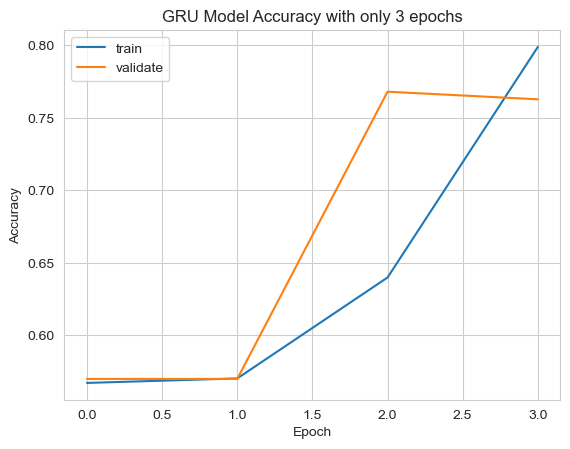

In [328]:
#accuracy
plt.plot(submit_gru.history['accuracy'])
plt.plot(submit_gru.history['val_accuracy'])
plt.title('GRU Model Accuracy with only 3 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'])
plt.show();

### Results and Analysis

Now with my models trained, I am going to see how they perform against the test/submission data within the Kaggle competition.

To start, I will need to prep the test data set. I will do the same steps I did above with the training data set, including cleaning, lemmatizing, and tokenizing the data.

In [329]:
# apply to testing data
functions = [remove_urls, remove_html, remove_tags, lower_case, clean_lemmatize]
for func in functions: 
    testdata['text'] = testdata['text'].apply(func) 

In [330]:
# tokenize 
test_token_X = tokenizer.texts_to_sequences(testdata['text'].values)
test_token_X = pad_sequences(token_X)
test_token_X.shape
token_df = pd.DataFrame(test_token_X)
for col_id in range(test_token_X.shape[1]):
    testdata[str(col_id)] = token_df[col_id]

In [331]:
# final look at data before starting model
testdata = testdata.drop('text', axis=1)
testdata = testdata.drop('keyword', axis=1)
testdata = testdata.drop('location', axis=1)

testdata.head()

,id,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4055,463,166,77,1425,4056,15
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,116,3,158,511,1084
2,3,0,0,0,0,0,0,0,0,0,...,1557,1426,1913,464,326,172,1913,464,376,964
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,2582,10,4057,86,172,376,40
4,11,0,0,0,0,0,0,0,0,0,...,0,0,0,37,1085,121,1558,195,86,103


In [332]:
testdata.head()
test_preds_LSTM = model_LSTM.predict(testdata.loc[:, testdata.columns != 'id'])
test_preds_GRU = submit_model_GRU.predict(testdata.loc[:, testdata.columns != 'id'])

102/102 [==============================] - 1s 7ms/step


In [333]:
submission_results_LTSM = np.transpose(test_preds_LSTM)[0]
submission_results_LTSM = list(map(lambda x: 0 if x < 0.5 else 1, test_preds_LSTM))

#convert to dataframe and submit to CSV
submission_LTSM = pd.DataFrame({'id':testdata['id'], 'target':submission_results_LTSM})
submission_LTSM.to_csv('submission_LTSM.csv', index=False)

In [334]:
submission_results_GRU = np.transpose(test_preds_GRU)[0]
submission_results_GRU = list(map(lambda x: 0 if x < 0.5 else 1, test_preds_GRU))

#convert to dataframe and submit to CSV
submission_GRU = pd.DataFrame({'id':testdata['id'], 'target':submission_results_GRU})
submission_GRU.to_csv('submission_GRU.csv', index=False)

After submitting to Kaggle, I got the following scores for my LSTM and GRU models.

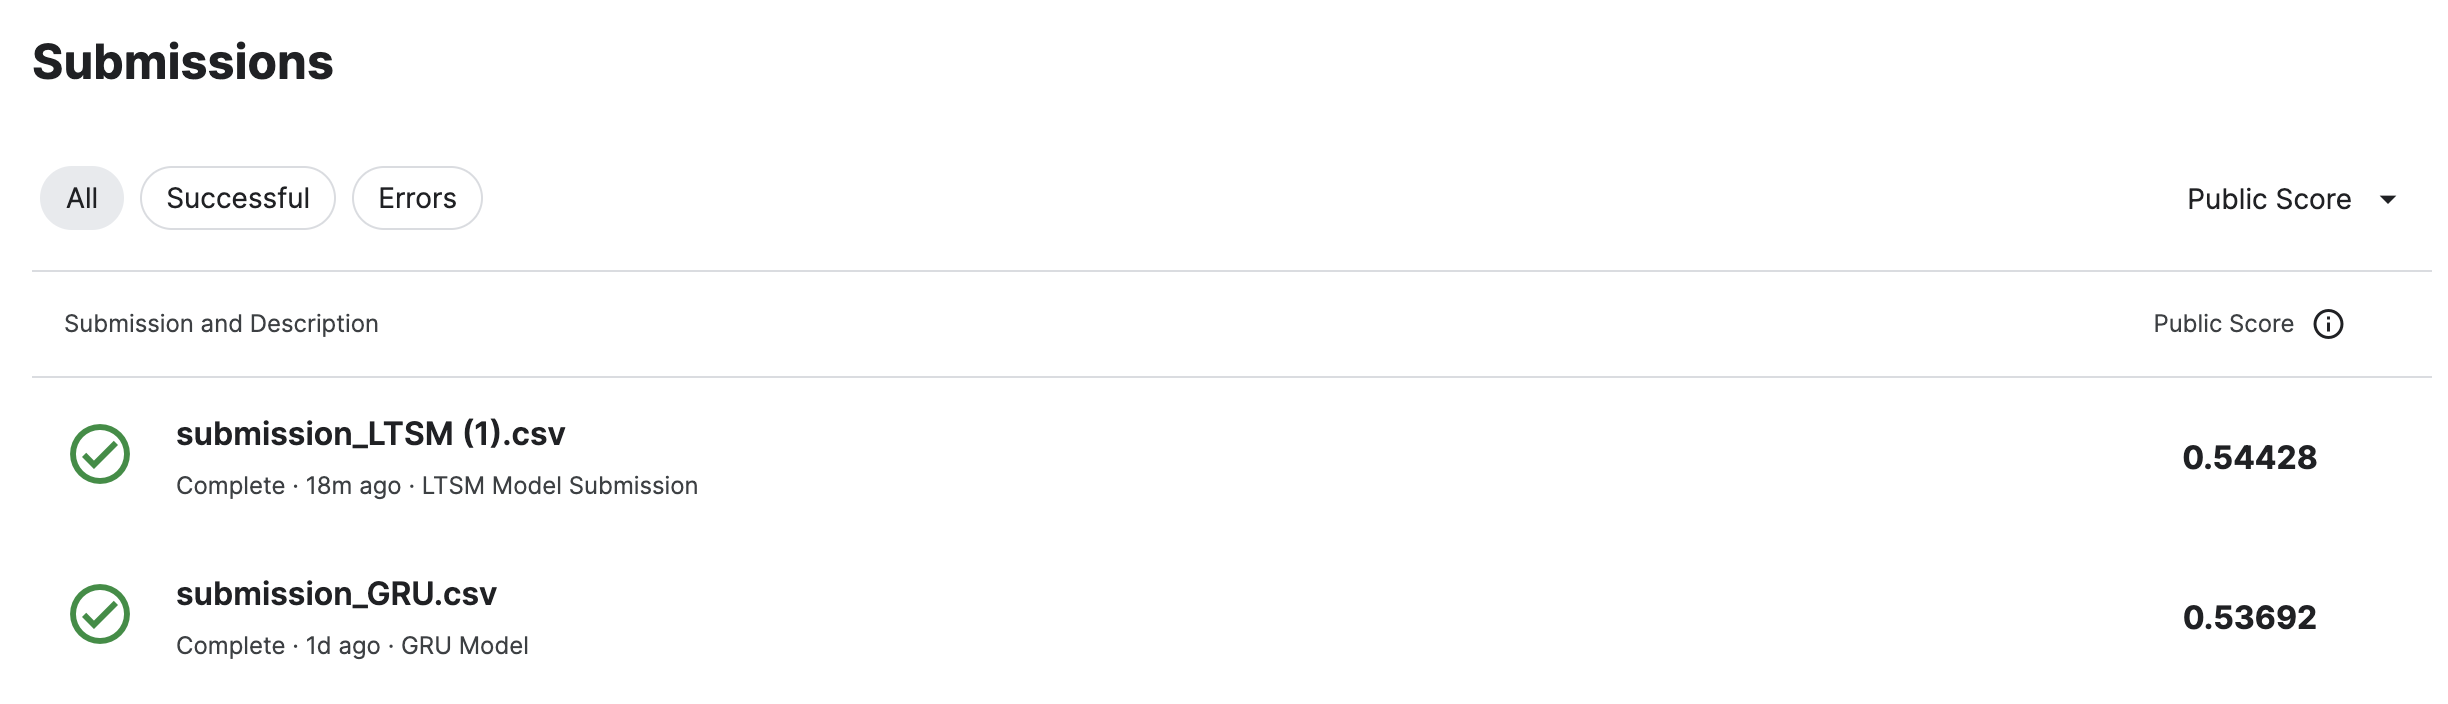

### Conclusion

The LTSM and GRU models performed very similarly, at around 54%. A few conclusions I can draw from this effort:
* The scores are not super high, with fairly simple models and data cleaning. Without actually investigating every tweet individually and/or incorporating the other fields such as location and keyword, the cleaning/tokenization process can only go so far.
* With future iterations of this project, I could work on more parameter optimization. I could try other optimizers such as RMSProp, or I could try a different learning rate. I tried to adjust epochs, but more could be done.
* With future iterations, I could also try a more complex model architecture for both LSTM or GRU.
* Furthermore, I could have tried a different NLP method instead of tokenization.

Overall, I really enjoyed working on this project and I enjoyed the first taste of NLP in our masters program! Thanks for reading!